# Clipping Approaches  in  Python  with RioXarray

Clipping can be affected by:
* Using the inbuilt rxr `crs=` parameter vs. transformed the `crs` with gpd
* The `all_touched` parameter

## Getting set up with libraries and the Cold Springs Fire data

In [2]:
### load our packages 
from glob import glob
import os
import warnings

import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
from shapely.geometry import box, Polygon, mapping
import rasterio as rio
import earthpy as et
# from osgeo import gdal

### earth py pre-packaged data on Cold Springs fire
et.data.get_data('cs-test-naip')
et.data.get_data('cold-springs-fire')
et.data.get_data('cold-springs-modis-h4')

### grab some additional data from FigShare
et.data.get_data(url="https://ndownloader.figshare.com/files/21941085")

### make a path for it
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))
warnings.simplefilter('ignore')

### configure rioxarray (we don't want it to export the grid mapping metadata, for simplicity)
rioxarray_option = rxr.set_options(export_grid_mapping=False)

In [3]:
### open fire boundary

### make file path for shapefiles
fire_boundary_path = os.path.join(
    "cold-springs-fire",
    "vector_layers",
    "fire-boundary-geomac",
    "co_cold_springs_20160711_2200_dd83.shp")

### open fire shapefile 
fire_boundary = gpd.read_file(fire_boundary_path)

## Open Landsat Data


In [4]:
### make data path for rasters
data_path = os.path.join("earthpy-downloads",
                         "landsat-coldsprings-hw")

### open a  single file
### list returned files in ascending order
all_files = sorted(

    ### find files that fit the pattern:
    glob(os.path.join(
        data_path,
        "LC080340322016062101T1-SC20200306230017",
        "*band[3-7]*.tif")))

### select the first file from the list
band_path = all_files[0]

### check that it exists
band_path, os.path.exists(band_path)

('earthpy-downloads\\landsat-coldsprings-hw\\LC080340322016062101T1-SC20200306230017\\LC08_L1TP_034032_20160621_20170221_01_T1_sr_band3.tif',
 True)

## Clip Landsat Data

In [5]:
# Get bounding box in the Landsat CRS

### open landsat image and get its crs
with rio.open(band_path) as src:
    landsat_crs = src.crs

### reproject fire perimeter to match landsat crs 
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)

### make a bounding box using reprojected fire boundary
### box() makes a rectangular bounding box around the area of interest
crop_bound_utmz13_box = [box(*fire_boundary_utmz13.total_bounds)]

### make the boundaing box a gdp
landsat_box = gpd.GeoDataFrame(geometry=crop_bound_utmz13_box)

### Reprojecting using rioxarray
Above, we reprojected polygons using Geopandas. We could also do this using rioxarray and the command `crs=...`

In [7]:
### make a bounding box using the fire boundary (in its original crs -- not reprojected)
crop_bound_box = [box(*fire_boundary.total_bounds)]

# This is how rioxarray is projecting the data when you use crs=
# The reprojection is actually slightly different vs how Geopandas does it

### reproject using the transform_geom command from the warp module in rasterio: rio.warp
landsat_transform = rio.warp.transform_geom(

    ### transform_geom takes the current crs, the target crs, and the geometry we're reprojecting
    fire_boundary.crs, landsat_crs, crop_bound_box)

### now make a gpd with the reprojected bounding box
### Polygon() makes a polygon object from a list of coordinates
landsat_transformed_bounds = gpd.GeoDataFrame(geometry=[Polygon(

    ### get the polygon coordinates of the reprojected geometry
    landsat_transform[0]['coordinates'][0][::1])], 
    
    ### use the crs of the landsat image
    crs=landsat_crs)

In [6]:
### Make plotting function

def plot_with_boundaries(boundary, bbox, raster):
    """
    Plot a raster and its clipping boundary
    
    Parameters
    ----------
      boundary : gpd.GeoDataFrame
        The boundary to plot
        
      bbox : gpd.GeoDataFrame
        The bounds used to clip
        
      raster : xr.Dataset
        The data to plot
      
      
    Returns
    -------
      boundary_plot : a matplotlib figure
    """
    # Plot the Data
    f,  ax = plt.subplots(figsize=(14, 5))
    raster.plot(
        ax=ax,
        add_colorbar=False)

    boundary.plot(
        ax=ax,
        edgecolor="yellow",
        facecolor="none",
        linewidth=2)

    bbox.plot(
        ax=ax,
        edgecolor="red",
        facecolor="none",
        linewidth=1)
    
    return ax
    

We'll see that based on how we reproject and how we clip will slightly change our results:

### Landsat Case 1
How we're reprojecting: `crs=...`

How we're clipping: `all_touched=True`

[Text(0.5, 1.0, 'All Touched =  The clip extent is slightly skewed, leaving a white edge on the left')]

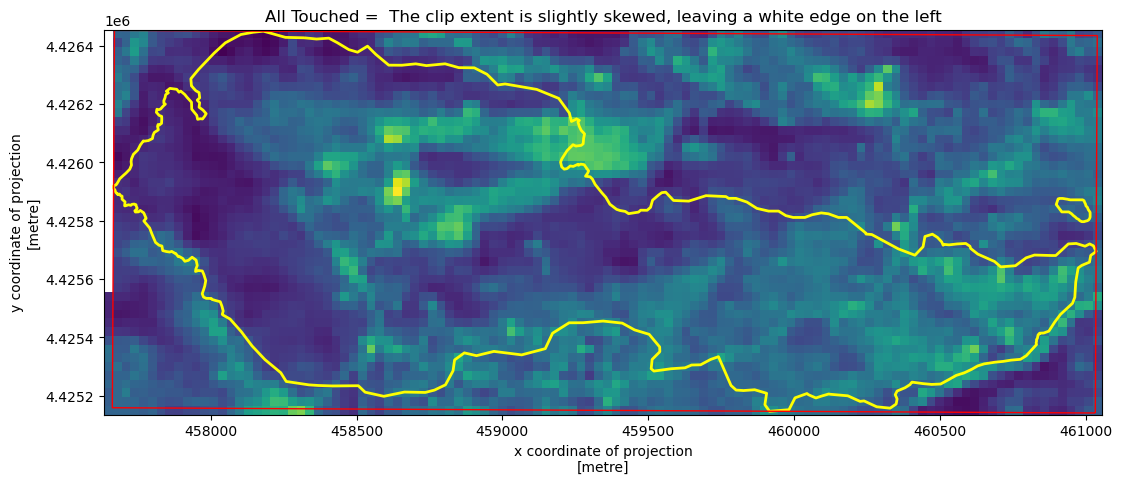

In [8]:
### open and define what we're plotting
band = (

    ### open the landsat raster
    rxr.open_rasterio(
        band_path,  

        ### mask  no data values
        masked=True)

    ### clip raster to bounding box
    .rio.clip(

        ### clip based on the bounding box, not the actual fire perimeter
        crop_bound_box,

        ### set crs of bounding box --> reproject raster to match if necessary
        crs=fire_boundary.crs,

        ### keep all pixels touched by perimeter of bounding box
        all_touched=True,
        from_disk=True)
    
    ### drop dimensions we don't need
    .squeeze()
)

### plot
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)
ax.set(title=("All Touched =  The clip extent is slightly skewed, "
              "leaving a white edge on the left"))

Things to notice: 
1. Since we clipped with `all_touched = True`, we keep all pixels that overlap with the bounding box (even if just by a tiny amount).
2. The bounding box is slightly tilted, compared to the raster data, which means that the bounding box perimeter doesn't totally align with pixel edges. This causes that white area where the pixels are dropped because they don't intercept the boundary.

This seems to be because rioxarray is using a slightly different way of reprojecting than geopandas is.


### Landsat Case 2
How we're reprojecting: `crs=...`

How we're clipping: `all_touched=False`

[Text(0.5, 1.0, 'All_touched = False, white edge on the top and right as well')]

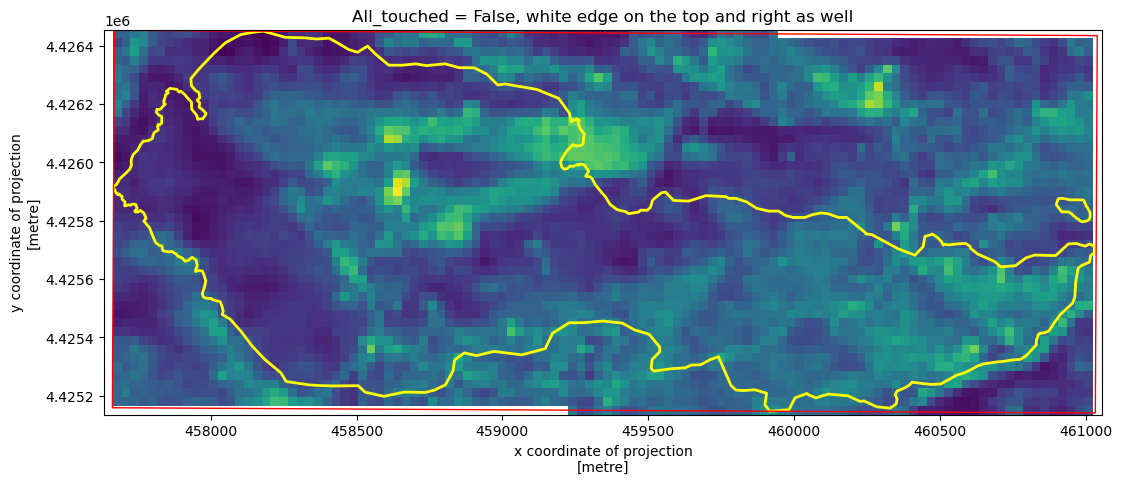

In [10]:
### open and define what we're plotting
### this will be the same as in case 1, except for all_touched
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(
        crop_bound_box,
        crs=fire_boundary.crs,

        ### set all_touched = False -- only keep pixels that are fully within bounding box perimeter
        all_touched=False, 
        from_disk=True)
    .squeeze()
)

### plot
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_transformed_bounds, band)
ax.set(title="All_touched = False, white edge on the top and right as well")

Here, we have more pixels dropped. Depending on the data, this could impact our results.

It appears as if the white edges are  artifacts of how the data are reprojected 
above. It thus might be better practice to reproject first.  

### Landsat Case 3
How we're reprojecting: reproject bounding box prior to clipping -- don't use `crs=...`

How we're clipping: `all_touched=True`

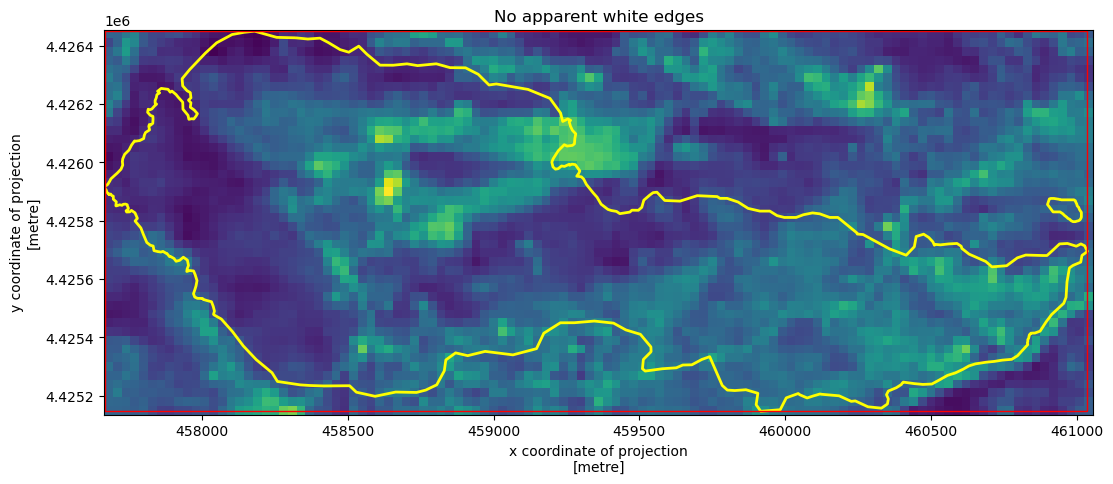

In [9]:
### open and define what we're plotting
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(

        ### clip to the bounding box we already reprojected
        crop_bound_utmz13_box,
        all_touched=True,
        from_disk=True)
    .squeeze()
)

# Plot the data
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_box, band)
ax.set(title="No apparent white edges")
plt.show()

### Landsat Case 4
How we're reprojecting: reproject bounding box prior to clipping -- don't use `crs=...`

How we're clipping: `all_touched=False`

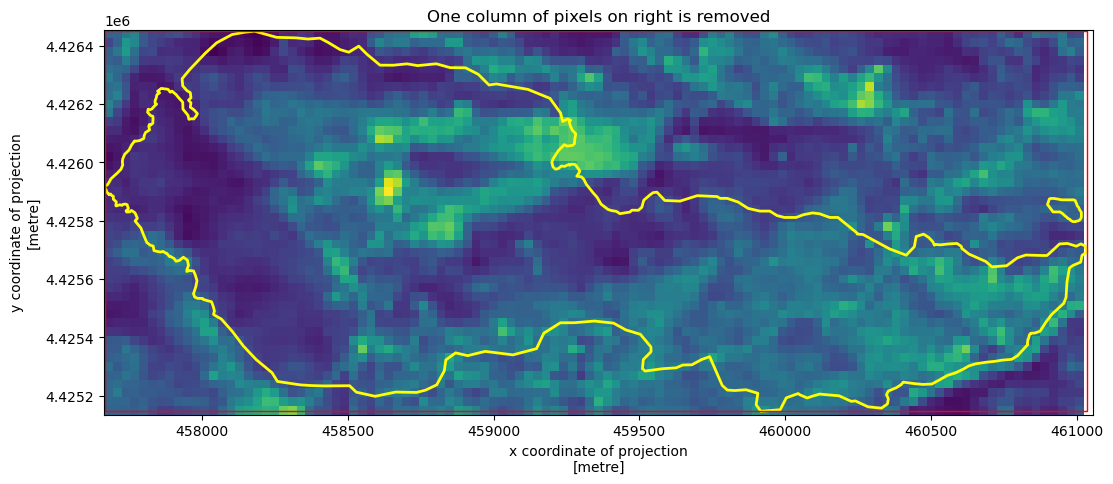

In [11]:
### open and define what we're plotting
band = (
    rxr.open_rasterio(
        band_path,
        masked=True)
    .rio.clip(
        crop_bound_utmz13_box,
        all_touched=False,
        from_disk=True)
    .squeeze()
)

# Plot the data
ax = plot_with_boundaries(
    fire_boundary_utmz13, landsat_box, band)
ax.set(title="One column of pixels on right is removed")
plt.show()

### Conclusions  -  Landsat  Data  Processing

It is clearly cleaner (less artifacts) to NOT use `crs=` and to 
reproject the fire boundary first. The reproject  process in rioxarray
seems to modify the data in a way that is undesirable causing edge artifacts



##  Open and clip MODIS Data
This is even more apparent with MODIS data because the pixels are larger:

In [12]:
### locate modis files
modis_h4_path = glob(os.path.join(

    ### grab the first modis file if there are more than 1
    "cold-springs-modis-h4", "17_july_2016", "*.hdf"))[0]

### specify which band (surface reflectance)
desired_bands = ["sur_refl_b01_1"]

### print the path
modis_h4_path

'cold-springs-modis-h4\\17_july_2016\\MOD09GA.A2016199.h09v05.006.2016201065406.hdf'

In [ ]:
# reproject fire boundary to sinusoidal

### open the modis file
with rio.open(modis_h4_path) as src:

    ### loop through layers/bands in file
    for data in src.subdatasets:

        ### open each layer and retrieve crs
        with rio.open(data) as data_src: 
            modis_crs = data_src.crs

### reproject fire boundary to match modis crs
fire_boundary_modis = fire_boundary.to_crs(modis_crs)

### make rectangular bounding box for fire boundary
fire_box = [box(*fire_boundary.total_bounds)]

### make the bounding box a gpd
modis_box = gpd.GeoDataFrame(geometry=[box(*fire_boundary_modis.total_bounds)])

### now do it using crs= in rioxarray
modis_transform = rio.warp.transform_geom(fire_boundary.crs, modis_crs, fire_box)
modis_transformed_bounds = gpd.GeoDataFrame(
    geometry=[Polygon(modis_transform[0]['coordinates'][0][::1])], crs=modis_crs)

### MODIS Case 1
How we're reprojecting: `crs=...`

How we're clipping: `all_touched=True`

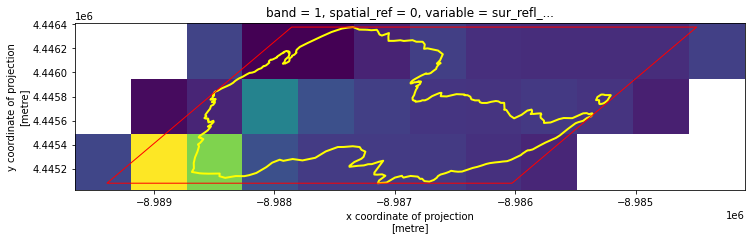

In [21]:
### open and define what to plot

### make a box for cropping modis based on the boundaries of the fire perimeter
modis_crop_box = [box(*fire_boundary.total_bounds)]

### open the modis data
modis_band = rxr.open_rasterio(modis_h4_path,
                               
                               ### mask no data pixels
                               masked=True,

                               ### select band and clip using bounding box
                               variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                     
                                                                     ### reproject using crs =
                                                                     crs=fire_boundary.crs,

                                                                     ### keep all pixels touched by perimeter
                                                                     all_touched=True,

                                                                     ### read it from the disk (not the memory)
                                                                     ### drop extra dimensions
                                                                     from_disk=True).squeeze()

### convert raster to array
modis_band_arr = modis_band.to_array()

### plot using matplotlib

### make the plot, set size of axes
f, ax = plt.subplots(figsize=(12, 15))

### plot the modis data, without a color bar
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)

### plot fire boundary, reprojected to match modis using geopandas
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

### plot fire boundary, reprojected to match modis using crs = 
modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

Our bounding box is pretty skewed relative to the pixel grid because of how we reprojected it.

### MODIS Case 2
How we're reprojecting: `crs=...`

How we're clipping: `all_touched=False`

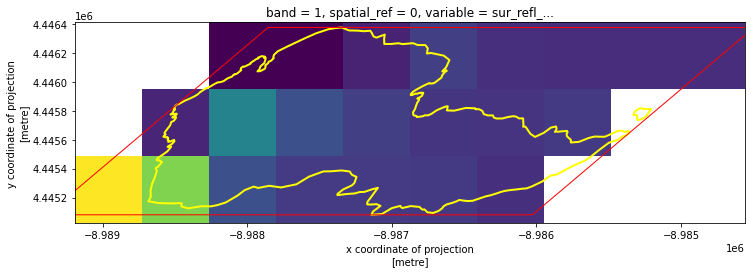

In [22]:
modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box,
                                                                       crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_transformed_bounds.plot(ax=ax,
                              facecolor="none",
                              edgecolor="red",
                              linewidth=1)

plt.show()

Our bounding box is pretty skewed relative to the pixel grid because of how we reprojected it, AND we've lost a bunch of data because we used `all_touched = False`

### MODIS Case 3
How we're reprojecting: reproject bounding box prior to clipping -- don't use `crs=...`

How we're clipping: `all_touched=True`

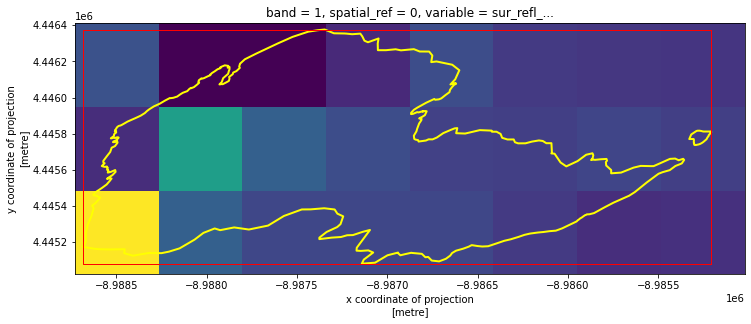

In [23]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=True,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

The bounding box is parallel to the raster pixels, and all the data are included.

### MODIS Case 4
How we're reprojecting: reproject bounding box prior to clipping -- don't use `crs=...`

How we're clipping: `all_touched=False`

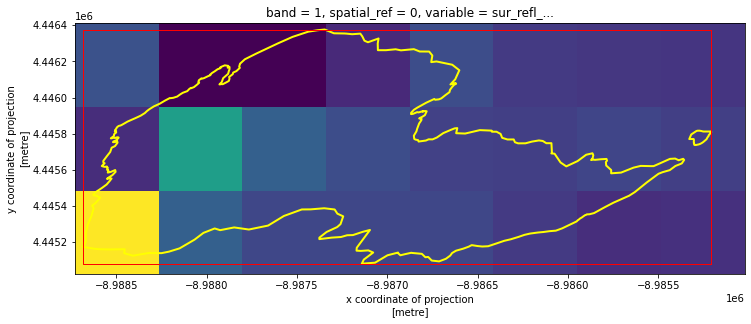

In [24]:
# reprojected box

modis_crop_box_reproj = [box(*fire_boundary_modis.total_bounds)]

modis_band_1 = rxr.open_rasterio(modis_h4_path,
                                 masked=True,
                                 variable=["sur_refl_b01_1"]).rio.clip(modis_crop_box_reproj,
                                                                       # crs=fire_boundary.crs,
                                                                       all_touched=False,
                                                                       from_disk=True).squeeze()

modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(ax=ax,
                    add_colorbar=False)
fire_boundary_modis.plot(ax=ax,
                         facecolor="none",
                         edgecolor="yellow",
                         linewidth=2)

modis_box.plot(ax=ax,
               facecolor="none",
               edgecolor="red",
               linewidth=1)

plt.show()

The bounding box is parallel to the raster pixels, and all the data are included.

### Conclusions  -  MODIS  Data  Processing

Much like Landsat, it is cleaner reproject the fire boundary first for MODIS. 



##  What about clipping with the geometry directly?

We have been clipping with a rectangular bounding box instead of complex geometry.

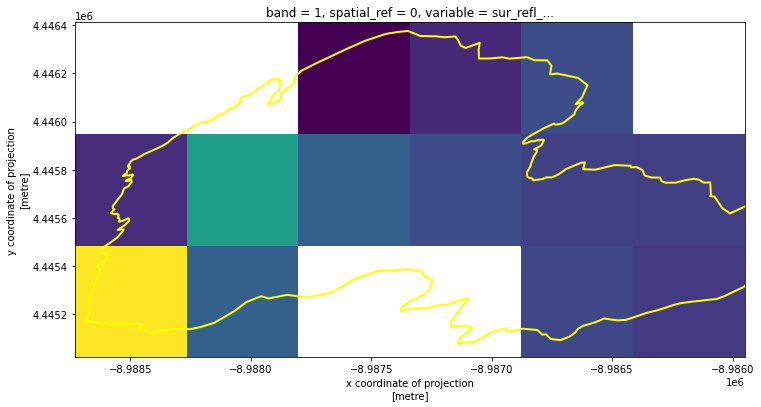

In [27]:
# Crop using the geometry rather than the bounding box

### open the modis data, just like we have been
modis_band_1 = (
    rxr.open_rasterio(
        modis_h4_path,
        masked=True,
        variable=["sur_refl_b01_1"])
    
    ### clip to the exact geometry of the reprojected fire boundary
    .rio.clip(
        fire_boundary_modis.geometry,
        all_touched=False,
        from_disk=True)
    .squeeze()
)


modis_band_arr = modis_band_1.to_array()

f, ax = plt.subplots(figsize=(12, 15))
modis_band_arr.plot(
    ax=ax,
    add_colorbar=False)
fire_boundary_modis.plot(
    ax=ax,
    facecolor="none",
    edgecolor="yellow",
    linewidth=2)

plt.show()

We lose several pixels (because boundary doesn't cross centroid of pixels)